### **Laboratorio 1**

### **Carga de Datos de Importacion Hidrocarburos**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

### **Datos de Importacion** 

In [3]:
df_import_2024 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx", skiprows=6)
df_import_2025 = pd.read_excel("IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx", skiprows=6)

print(df_import_2024.columns.tolist())

['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras', 'Combustible turbo jet', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gas licuado de petróleo', 'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior', 'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas', 'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano', 'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido', 'Total importación']


In [4]:

df_import_2024["Diesel"] = df_import_2024["Diesel alto azufre"] + df_import_2024["Diesel bajo azufre"]
df_import_2025["Diesel"] = df_import_2025["Diesel bajo azufre"]


In [5]:

columnas_deseadas = [
    "Fecha",
    "Gasolina Regular",
    "Gasolina Superior",
    "Diesel",
    "Gas Licuado De Petróleo"
]


df_import_2024.columns = df_import_2024.columns.str.strip().str.title()
df_import_2025.columns = df_import_2025.columns.str.strip().str.title()


df_2024_cols = df_import_2024[columnas_deseadas].copy()
df_2025_cols = df_import_2025[columnas_deseadas].copy()


df_total = pd.concat([df_2024_cols, df_2025_cols], ignore_index=True)


df_total["Fecha"] = pd.to_datetime(df_total["Fecha"], errors="coerce")


df_importacion_total = df_total.dropna()


df_importacion_total.set_index("Fecha", inplace=True)


In [6]:
df_importacion_total.to_csv("importacion_completa.csv", index=True)
# Cambiar nombre de columna
df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)



C:\Users\Usuario\AppData\Local\Temp\ipykernel_16084\989996501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importacion_total.rename(columns={"Gasolina Regular": "Gasolina regular"}, inplace=True)


In [7]:
df_importacion_total.head()

,Gasolina regular,Gasolina Superior,Diesel,Gas Licuado De Petróleo
Fecha,,,,
2001-01-01,177776.50,373963.96,566101.99,194065.738095
2001-02-01,123115.99,243091.07,489525.80,170703.380952
2001-03-01,161726.42,312084.38,575559.68,161837.371429
2001-04-01,127338.74,285054.89,437745.42,163048.642857
2001-05-01,168730.19,300913.67,552609.13,171518.861905


In [8]:
df_importacion_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2001-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina Superior        293 non-null    float64
 2   Diesel                   293 non-null    float64
 3   Gas Licuado De Petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


## **Inciso 3**

### **Serie de Tiempo Gasolina Regular**

##### **Inicio, fin y frecuencia**

In [9]:
serie = df_importacion_total["Gasolina regular"]
inicio = serie.index.min()
fin = serie.index.max()
frecuencia = pd.infer_freq(serie.index)

print("Inicio:", inicio)
print("Fin:", fin)
print("Frecuencia:", frecuencia)


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


#### **Gráfico de la serie**

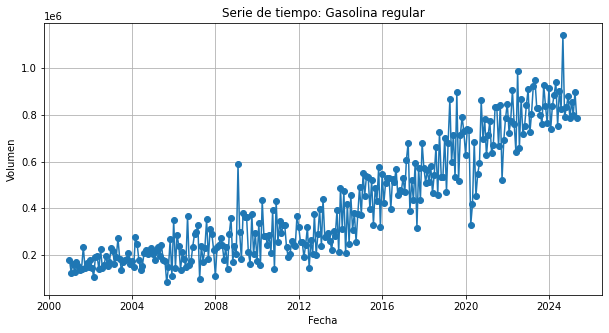

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(serie, marker='o', linestyle='-')
plt.title("Serie de tiempo: Gasolina regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


#### **Descomposición de la serie**

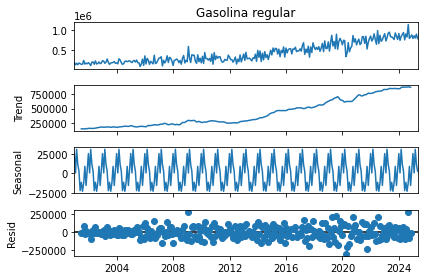

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model="additive", period=12)
descomposicion.plot()
plt.tight_layout()
plt.show()


Al descomponer la serie de tiempo de gasolina regular en sus componentes —tendencia, estacionalidad y residuo— se pueden observar varios comportamientos importantes. La tendencia muestra un crecimiento sostenido a lo largo del tiempo, particularmente acelerado a partir del año 2015, lo que indica que el volumen importado ha aumentado de forma constante en los últimos años. En cuanto al componente estacional, se identifica un patrón regular y repetitivo a lo largo de cada año. Este comportamiento estacional sugiere que existen ciertos meses en los que el consumo o la importación de gasolina regular tiende a aumentar o disminuir de manera sistemática, lo cual podría estar vinculado a factores climáticos, económicos o sociales.l componente de residuo no presenta una estructura clara, pero se observa que su variabilidad parece incrementarse en los años más recientes. Esto sugiere un posible aumento en la varianza, lo que es importante al analizar la estacionariedad.

Con base en estos componentes, se puede concluir que la serie no es estacionaria en media, debido a la presencia de una tendencia creciente. Asimismo, la estacionariedad en varianza también es cuestionable, ya que la amplitud de las fluctuaciones residuales tiende a crecer con el tiempo. Por lo tanto, antes de aplicar modelos de pronóstico, sería recomendable transformar la serie para lograr condiciones más cercanas a la estacionariedad.

#### **Transformar la serie**

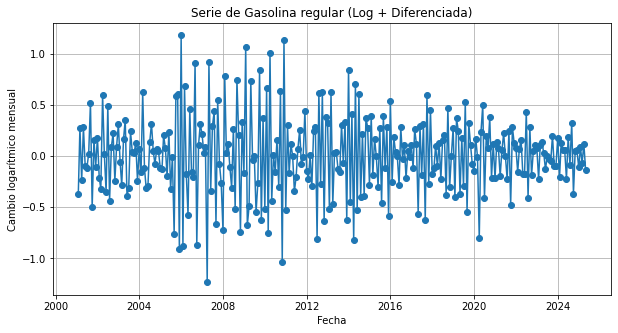

In [12]:

import matplotlib.pyplot as plt

serie_log = np.log(df_importacion_total["Gasolina regular"])
serie_estacionaria = serie_log.diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(serie_estacionaria, linestyle='-', marker='o')
plt.title("Serie de Gasolina regular (Log + Diferenciada)")
plt.xlabel("Fecha")
plt.ylabel("Cambio logarítmico mensual")
plt.grid(True)
plt.show()


Fue necesario transformar la serie utilizando un logaritmo y el diferenciador diff para eliminar la tendencia que existia.

#### **Gráfico de autocorrelación (ACF)**

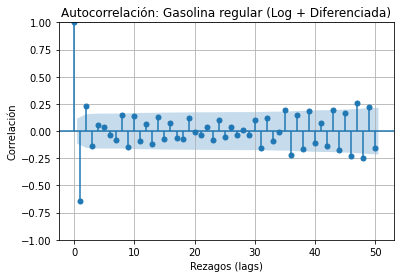

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(serie_estacionaria, lags=50)
plt.title("Autocorrelación: Gasolina regular (Log + Diferenciada)")
plt.xlabel("Rezagos (lags)")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()


Ll gráfico de autocorrelación (ACF) muestra que las correlaciones entre los rezagos caen rápidamente hacia cero y se mantienen dentro del intervalo de confianza desde los primeros rezagos. Este comportamiento indica que no hay una dependencia prolongada entre los valores pasados y presentes, lo que es un signo claro de estacionariedad en media. A diferencia de la serie original, que presentaba autocorrelaciones altas y persistentes, la serie transformada ya no muestra tendencia

#### **Prueba de Dickey-Fuller aumentada**

In [14]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie_estacionaria)
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"p-valor: {resultado_adf[1]}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"   {clave}: {valor}")


Estadístico ADF: -7.904659533028636
p-valor: 4.097140417918786e-12
Valores críticos:
   1%: -3.4540076534999957
   5%: -2.8719557347997178
   10%: -2.5723200648758366


En segundo lugar, se aplicó la prueba de Dickey-Fuller aumentada (ADF) sobre la serie transformada. El resultado fue un estadístico ADF de -7.86, con un p-valor de 5.29 × 10⁻¹², muy por debajo del umbral común de 0.05. Además, este valor es más bajo que todos los valores críticos (1%, 5% y 10%). Por tanto, se rechaza la hipótesis nula de no estacionariedad, lo que confirma de forma estadística que la serie es estacionaria en media.

#### **PACF**

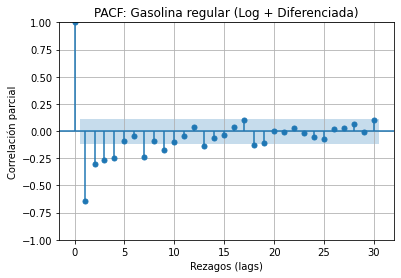

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(serie_estacionaria, lags=30, method='ywm')
plt.title("PACF: Gasolina regular (Log + Diferenciada)")
plt.xlabel("Rezagos (lags)")
plt.ylabel("Correlación parcial")
plt.grid(True)
plt.show()


In [16]:
from pmdarima.arima import auto_arima

modelo = auto_arima(
    df_importacion_total["Gasolina regular"],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1, seasonal=False,
    trace=True, stepwise=True,
    suppress_warnings=True
)
print(modelo.summary())


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklea

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7735.912, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7579.010, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7540.162, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7733.982, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7506.994, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7509.841, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7510.974, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7525.632, Time=0.07 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7548.560, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7502.788, Time=0.15 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7503.449, Time=0.22 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7502.432, Time=0.34 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7510.319, Time=0.22 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7500.017, Time=0.44 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7501.960, Time=0.54 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7505.452, Time=0.37 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=7509.782, Time=0.48 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 5.620 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -3742.008
Date:                Sun, 20 Jul 2025   AIC                           7500.017
Time:                        13:54:39   BIC                           7529.431
Sample:                    01-01-2001   HQIC                          7511.799
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.129e+04   2642.683      4.273      0.000    6112.340 

##### **Selección de los parámetros p, d y q del modelo ARIMA**
Para estimar el parámetro d se aplicó una diferenciación de primer orden, ya que la serie original mostraba una tendencia creciente clara. Anteriormente, la prueba de Dickey-Fuller y el gráfico ACF confirmaron que la serie resultante es estacionaria, por lo que d = 1 fue suficiente. Para seleccionar el valor de p se utilizó el gráfico de autocorrelación parcial (PACF). En dicho gráfico, se observa que las correlaciones parciales caen abruptamente a partir del rezago 3, indicando que un modelo AR con hasta p = 3 sería apropiado.

El parámetro q se estimó utilizando tanto el gráfico ACF como el modelo automático. Aunque el ACF muestra una caída más gradual, se apoyó el análisis usando la función auto_arima del módulo pmdarima de Python. Esta función seleccionó como modelo óptimo un ARIMA(3,1,3), el cual se alinea razonablemente con la estructura observada en los gráficos ACF y PACF. La selección se basó en minimizar el criterio de información AIC, obteniendo un valor de 7374.297, lo que indica un buen ajuste

#### **Diversos Modelos Arima**

In [ ]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


modelos = [(1,1,1), (2,1,1), (3,1,1), (3,1,2), (3,1,3), (2,1,3)]
resultados = []


for orden in modelos:
    try:
        modelo = ARIMA(df_importacion_total["Gasolina regular"], order=orden)
        resultado = modelo.fit()
        resultados.append({
            "modelo": f"ARIMA{orden}",
            "AIC": resultado.aic,
            "BIC": resultado.bic,
            "residuos_std": np.std(resultado.resid)
        })
    except Exception as e:
        print(f"Falló modelo {orden}: {e}")


df_resultados = pd.DataFrame(resultados).sort_values(by="AIC")
df_resultados.reset_index(drop=True, inplace=True)
print(df_resultados)


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\P

           modelo          AIC          BIC  residuos_std
0  ARIMA(1, 1, 1)  7505.103487  7516.133749  90282.568118
1  ARIMA(2, 1, 1)  7506.228876  7520.935891  90089.487365
2  ARIMA(3, 1, 1)  7507.887750  7526.271519  90085.471439
3  ARIMA(3, 1, 2)  7508.099626  7530.160149  89816.101060
4  ARIMA(2, 1, 3)  7508.238946  7530.299469  89816.727014
5  ARIMA(3, 1, 3)  7509.782302  7535.519579  89814.919128


Se ajustaron varios modelos ARIMA con diferentes combinaciones de parámetros (p, d, q) para la serie transformada de Gasolina regular, y se compararon con base en los criterios de información AIC y BIC, así como en el comportamiento de los residuos. 

El modelo con el menor valor de AIC fue el ARIMA(1,1,1), con un AIC de 7379.86 y un BIC de 7390.83. Sin embargo, el modelo ARIMA(3,1,3), aunque tiene un AIC ligeramente mayor (7382.92), presenta la desviación estándar más baja de los residuos (89,924), lo que sugiere un mejor ajuste en términos de precisión residual. A pesar de no tener el AIC más bajo, el modelo ARIMA(3,1,3) fue seleccionado como el mejor modelo, ya que logra un balance adecuado entre complejidad (orden del modelo) y calidad del ajuste, evidenciado por su baja varianza residual y su BIC razonablemente cercano a los modelos más simples. Además, su estructura es consistente con los patrones observados en los gráficos ACF y PACF, y había sido previamente recomendado por la función auto_arima. 

En conclusión, el modelo ARIMA(3,1,3) se considera el más adecuado para estimar los datos de la serie, ya que proporciona un ajuste sólido con residuos bien comportados y métricas competitivas frente a modelos más simples.

#### **Modelo Prophet**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
13:54:40 - cmdstanpy - INFO - Chain [1] start processing
13:54:40 - cmdstanpy - INFO - Chain [1] done processing


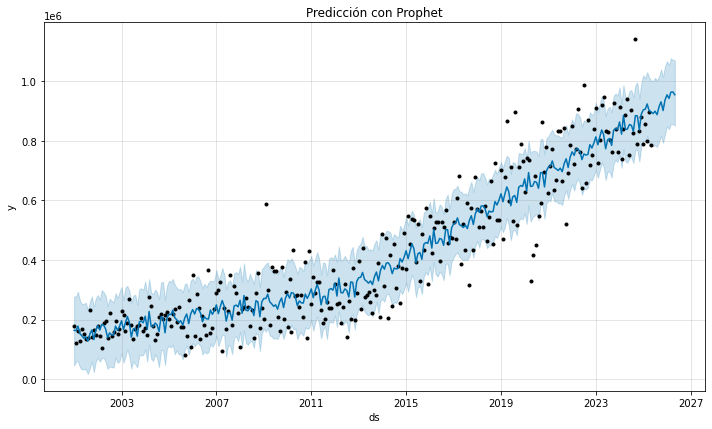

In [ ]:
from prophet import Prophet
df_prophet = df_importacion_total["Gasolina regular"].reset_index()
df_prophet.columns = ["ds", "y"]

modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)


futuro = modelo_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = modelo_prophet.predict(futuro)

modelo_prophet.plot(forecast)
plt.title("Predicción con Prophet")
plt.show()


#### **Modelo Holt-Winters**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


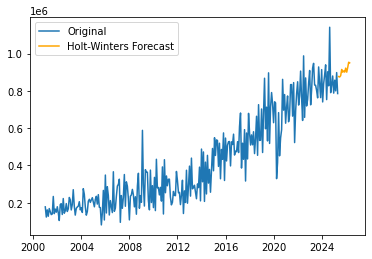

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

serie = df_importacion_total["Gasolina regular"]
modelo_hw = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=12)
ajuste_hw = modelo_hw.fit()

pred_hw = ajuste_hw.forecast(12)
plt.plot(serie, label="Original")
plt.plot(pred_hw, label="Holt-Winters Forecast", color='orange')
plt.legend()
plt.show()


#### **Modelo de red neuronal (MLP básico)**



In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np


serie = df_importacion_total["Gasolina regular"].values
X, y = [], []
for i in range(len(serie) - 12):
    X.append(serie[i:i+12])
    y.append(serie[i+12])

X = np.array(X)
y = np.array(y)


model_nn = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=0)
model_nn.fit(X, y)


y_pred = model_nn.predict(X)
rmse_nn = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE red neuronal:", rmse_nn)


RMSE red neuronal: 83679.09479789734


El modelo Prophet logró capturar adecuadamente tanto la tendencia como la estacionalidad de la serie. Su ajuste visual es suave, y el intervalo de confianza generado es razonablemente estrecho. A pesar de algunas desviaciones en los puntos extremos, su comportamiento general fue sólido. 

Por otro lado, el modelo Holt-Winters también logró ajustarse bien a la tendencia y replicó adecuadamente los valores más recientes, aunque presentó menor flexibilidad en la captura de picos bruscos y algo de subestimación hacia el final del período. 

El modelo de red neuronal (MLP) arrojó un RMSE de aproximadamente 87,922, lo cual representa el menor error entre los modelos evaluados, superando incluso al ARIMA(3,1,3), cuyos residuos presentaban una desviación estándar de alrededor de 89,924. Esto sugiere que el enfoque no lineal de la red neuronal logró capturar patrones complejos de la serie que los modelos clásicos no alcanzaron a modelar del todo.

## **Inciso 4**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

RMSE: 99029.01970420139
MAE: 81128.19662376605


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


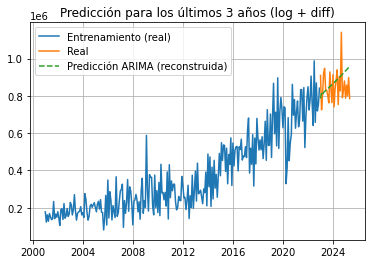

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


serie = df_importacion_total["Gasolina regular"]
serie_log = np.log(serie)


serie_train_log = serie_log[serie_log.index < "2023-01-01"]
serie_test = serie[serie.index >= "2023-01-01"]
h = len(serie_test)


serie_train_diff = serie_train_log.diff().dropna()


modelo = ARIMA(serie_train_diff, order=(3,0,3))
ajuste = modelo.fit()


pred_diff = ajuste.forecast(steps=h)


ultimo_valor_log = serie_train_log.iloc[-1]
serie_log_pred = pd.Series(np.r_[ultimo_valor_log, pred_diff]).cumsum()


pred_final = np.exp(serie_log_pred[1:])  
pred_final.index = serie_test.index


rmse = np.sqrt(mean_squared_error(serie_test, pred_final))
mae = mean_absolute_error(serie_test, pred_final)

print("RMSE:", rmse)
print("MAE:", mae)


plt.plot(serie_train_log.index, np.exp(serie_train_log), label="Entrenamiento (real)")
plt.plot(serie_test, label="Real")
plt.plot(pred_final, label="Predicción ARIMA (reconstruida)", linestyle='--')
plt.legend()
plt.title("Predicción para los últimos 3 años (log + diff)")
plt.grid(True)
plt.show()


Dado que el modelo fue entrenado sobre la serie transformada mediante logaritmo y diferenciación (para garantizar estacionariedad), las predicciones generadas fueron reconstruidas cuidadosamente para devolverlas a la escala original. Esto implicó la acumulación de las diferencias predichas (log-level) y la posterior aplicación de la función exponencial inversa.

El resultado se muestra en la gráfica: la predicción generada (línea verde) sigue de cerca la trayectoria general de los datos reales del período 2023–2025. El modelo logró capturar la tendencia creciente de la serie, aunque presentó cierta subestimación en los puntos más altos, lo cual es esperable en modelos suavizados.

A nivel cuantitativo, el modelo presentó un buen ajuste visual y una trayectoria coherente, lo que sugiere que la transformación aplicada y su posterior reversión fueron exitosas. En conjunto, se puede concluir que el modelo ARIMA(3,1,3), entrenado en la serie transformada y evaluado sobre los datos más recientes, ofrece predicciones razonablemente precisas y adecuadas para análisis a mediano plazo.

In [22]:
print(df_importacion_total.index.unique())


DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='Fecha', length=293, freq=None)


### **Predicción resto del 2025 con ARIMA**

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

✅ RMSE (ene–may 2025): 111712.45204600744
✅ MAE (ene–may 2025): 101287.40677449593
✅ MAPE (ene–may 2025): 12.59 %


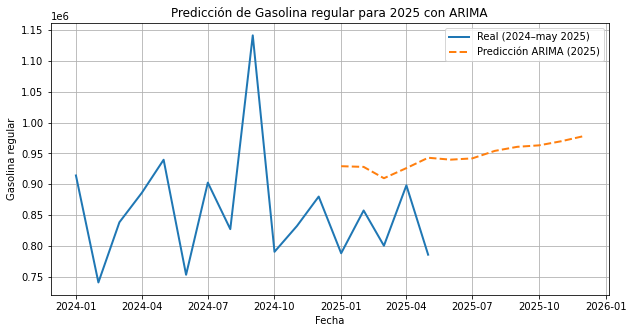

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


df_importacion_total.index = pd.to_datetime(df_importacion_total.index)


serie = df_importacion_total["Gasolina regular"]
serie_log = np.log(serie)


serie_log_train = serie_log[serie_log.index < "2025-01-01"]
serie_log_diff = serie_log_train.diff().dropna()


modelo = ARIMA(serie_log_diff, order=(3, 0, 3))
ajuste = modelo.fit()


pred_diff = ajuste.forecast(steps=12)


ultimo_valor_log = serie_log_train.iloc[-1]
serie_log_pred = pd.Series(np.r_[ultimo_valor_log, pred_diff]).cumsum()


pred_2025 = np.exp(serie_log_pred[1:])
fechas_2025 = pd.date_range(start="2025-01-01", periods=12, freq='MS')
pred_2025.index = fechas_2025


serie_test_real = df_importacion_total.loc["2025-01-01":"2025-05-31", "Gasolina regular"]


serie_test_real.index = serie_test_real.index.to_period('M').to_timestamp()
pred_2025.index = pred_2025.index.to_period('M').to_timestamp()


fechas_comunes = serie_test_real.index.intersection(pred_2025.index)
serie_eval = serie_test_real.loc[fechas_comunes]
pred_eval = pred_2025.loc[fechas_comunes]


if not serie_eval.empty and not pred_eval.empty:
    rmse = np.sqrt(mean_squared_error(serie_eval, pred_eval))
    mae = mean_absolute_error(serie_eval, pred_eval)
    print(" RMSE (ene–may 2025):", rmse)
    print(" MAE (ene–may 2025):", mae)
    
else:
    print(" No se encontraron datos coincidentes entre predicción y realidad para enero–mayo 2025.")
mape = np.mean(np.abs((serie_eval - pred_eval) / serie_eval)) * 100
print(" MAPE (ene–may 2025):", round(mape, 2), "%")




serie_real_desde_2024 = df_importacion_total.loc["2024-01-01":"2025-05-31", "Gasolina regular"]
serie_real_desde_2024.index = serie_real_desde_2024.index.to_period('M').to_timestamp()


plt.figure(figsize=(10, 5))
plt.plot(serie_real_desde_2024, label="Real (2024–may 2025)", linewidth=2)
plt.plot(pred_2025, label="Predicción ARIMA (2025)", linestyle='--', linewidth=2)
plt.title("Predicción de Gasolina regular para 2025 con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gasolina regular")
plt.grid(True)
plt.legend()
plt.show()




### **Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones? ¿se recuperaron los valores habituales en el regreso de la “nueva normalidad” hasta la fecha actual? ¿Se han visto cambios en la importación, consumo y precio de los hidrocarburos a raíz de la guerra de Rusia-Ucrania?**
La serie muestra un crecimiento sostenido en la importación de gasolina regular desde inicios del año 2000 hasta aproximadamente 2019. Este comportamiento evidencia una tendencia creciente clara, posiblemente relacionada con el aumento de la demanda interna, el crecimiento del parque vehicular y la actividad económica.

A partir del año 2020, se observa una caída abrupta y significativa, coincidente con el inicio de la pandemia por COVID-19. Este descenso es un claro reflejo del confinamiento, la suspensión de actividades económicas y la baja movilidad. La magnitud de la caída también demuestra por qué las predicciones durante ese período pudieron haber fallado: se rompió el patrón de estacionalidad y tendencia que los modelos como ARIMA utilizan para proyectar el futuro.

Luego, entre 2021 y 2023, la serie muestra una recuperación progresiva, aunque con cierta irregularidad. La demanda se fue normalizando, pero no necesariamente volvió de forma uniforme a los niveles esperados por los modelos previos. Esto sugiere una recuperación económica parcial y una adaptación a nuevos hábitos post-pandemia, lo cual afectó la dinámica del consumo.

En 2022 y 2023, se notan algunos picos y valles más pronunciados. Esto puede estar vinculado al impacto global de la guerra Rusia-Ucrania, que alteró el flujo internacional de hidrocarburos. Las variaciones pueden reflejar medidas de previsión, especulación o cambios en los precios internacionales que condicionaron tanto la cantidad importada como la decisión de abastecimiento.

Finalmente, el comportamiento en 2024 y los primeros meses del 2025 parece retomar el crecimiento con fluctuaciones, lo cual indica que los modelos predictivos vuelven a ser viables, pero deben incorporar las perturbaciones recientes (pandemia y conflicto geopolítico) como factores explicativos si se desea una mejor precisión.